# Exercise 3

## Bioassay Experiment

In the Bioassay Experiment the data can be modeled as $(x_i, n_i, y_i)$ (i=1,...,k) where $x_i$ is the $i$th of the k=4 dose levels administered to $n_i$ animals where $y_i$ subsequently had a positive response (Death).
Within groups it is possible to assume that the distribution of the responses is $y_i\mid \theta_i \sim \text{Bin}(n_i,\theta_i)$, where $\theta_i$ is the probability of death at dose $x_i$. The so called "dose-response relation" can then be modeled as $\text{logic}(\theta_i) = \alpha + \beta x_i$

Using this model the likelihood for each group can be given as follows:
\begin{equation}
p(y_i\mid \alpha, \beta, n_i, x_i) \propto [\text{logit}^{-1}(\alpha+\beta x_i)]^{y_i}[\text{logit}^{-1}(\alpha+\beta x_i)]^{n_i-y_i}
\end{equation}

Now it is also possible to compute the posterior distribution of the parameters $\alpha, \beta$ if vi are given a prior distribution of the parameters $p(\alpha, \beta)$. The posterior is then:
\begin{equation}
p(\alpha,\beta\mid y,n,x) \propto p(\alpha,\beta)\prod\limits_{i=1}^k p(y_i\mid\alpha,\beta,n_i,x_i)
\end{equation}

## Problem 3.1 (Metropolis Alg.)

### Some Theory 

In this problem we will try to do inference on the Bioassay data using the Metropolis algorithm. We are instructed to use a uniform prior $p(\alpha,\beta) \propto 1$. In such a case the posterior distribution is equal to the product of the group likelihoods: 
\begin{equation}
p(\alpha,\beta\mid y,n,x) \propto \prod\limits_{i=1}^k p(y_i\mid\alpha, \beta, n_i, x_i)
\end{equation}

It was decided to run 5 independent chains thus 5 starting points are needed. The starting points was distributed around the maximum likelihood estimation of $(\alpha,\beta)$ using the data. The estimate was $(\hat\alpha,\hat\beta) = (0.8,7.7)$, and the starting points was selected as: $(\alpha_{0,1},\beta_{0,1}) = (-4,-9)$, $(\alpha_{0,2},\beta_{0,2}) = (-4,30)$, $(\alpha_{0,3},\beta_{0,3}) = (9,-9)$, $(\alpha_{0,4},\beta_{0,4}) = (9,30)$, and $(\alpha_{0,5},\beta_{0,5}) = (2,15)$

All chains in the Metropolis algorithm used the same jumping distribution, a normal distribution $N((\alpha_{t-1,i},\beta_{t-1,i}),2 \cdot I)$, where $I$ is the 2x2 Identity matrix.

Under this model the density ration can be calculated as:
\begin{equation}
r = \exp[\log(p(\alpha^*,\beta^*\mid y,n,x)) - \log(p(\alpha_{t-1,i},\beta_{t-1,i}\mid y,n,x))]
\end{equation}

This is used to get the acceptance proposal which subsequently is used in the rule that is used to keep or reject the proposal sample:

\begin{equation}
  (\alpha_{t,i},\beta_{t,i})=\begin{cases}
    (\alpha_i^*,\beta_i^*), & \text{if $\gamma \lt ap$}.\\
    (\alpha_{t-1,i},\beta_{t-1,i}), & \text{otherwise}.
  \end{cases}
\end{equation}

where $(\alpha_i^*,\beta_i^*)$ is the proposal sample, $ap$ is the acceptance proposal, and $\gamma$ is a uniform random variable in [0,1].


Other then that we choose to draw 3000 samples for each chain using 5 chains, and we will see if the algorithm converges using the $\hat R$ calculation on both $\alpha$ and $\beta$

### Code base

In [134]:
%matplotlib inline

import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import utilities_and_data.psrf as util

In [82]:
#Data
x = np.array([-.86, -.30, -.05, .73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

In [83]:
def bioassaylp(a,b,x,y,n):
    '''
    unnormalized log posterior density for bioassay (assuming uniform prior)
    '''
    
    # these help using chain rule in derivation
    t = a + b*x
    et = np.exp(t)
    z = et/(1.+et)
    
    # negative log posterior (error function to be minimized)
    lp = np.sum(y*np.log(z)+ (n-y)*np.log(1.-z))
    return(lp)

#### Estimating the posterior using conjungates

In [186]:
# Estimate posterior with prior p(alpha,beta) ~  1
alpha = np.linspace(-5,10,500)
beta = np.linspace(-10,40,500)
likelihood = np.zeros((500,500))
for i, a in enumerate(alpha):
    for j, b in enumerate(beta):
        likelihood[j,i] = np.exp(bioassaylp(a,b,x,y,n))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


#### metropolis alg.

In [136]:
# Init

N = 3000
warmup = N//2
starters = np.array([[-4, -9], [-4, 30], [9, 30], [9, -9], [2, 15]])
sigma  = np.array([[2,0], [0,2]])

# allocate space for alg results
M  = np.zeros((N,2,starters.shape[0]))
M[0,0,:] = starters[:,0]
M[0,1,:] = starters[:,1]

In [143]:
for j, theta_t in enumerate(starters):
    for i in np.arange(1,N):
        # draw from the jumping distribution 
        mu = theta_t
        theta_star = multivariate_normal.rvs(mu,sigma,1)
        # Calculate probability
        p_theta_t = bioassaylp(theta_t[0],theta_t[1],x,y,n)
        p_theta_star = bioassaylp(theta_star[0],theta_star[1],x,y,n)
        #compute r
        r = np.exp(p_theta_star-p_theta_t)
        # Then the acceptance propocal 
        ap = np.min([r,1])
        
        if np.random.rand(1) < ap:
            theta_t = theta_star
            M[i,:,j] = theta_t
        else:
            M[i,:,j] = theta_t

#### Calculate point stats. and view the results

Statistics of alpha 
 Median: 1.17927583144
 95% confidence interval: [-0.544141559328, 3.67518650714] 

Statistics of beta 
 Median: 10.6510431899
 95% confidence interval: [3.59547681921, 24.1754139863]


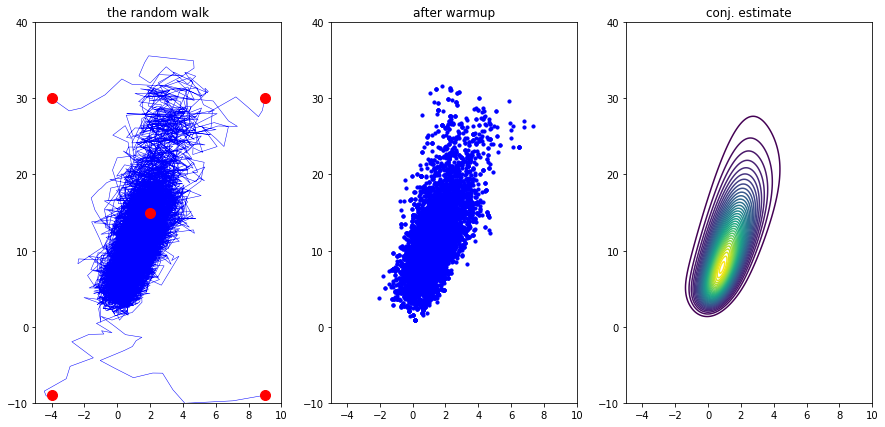

In [228]:
#Calculate point stats

# combine alpha and beta over the chains after warmup (aw)
alpha_aw = M[warmup:,0,:].reshape((warmup*5))
beta_aw = M[warmup:,1,:].reshape((warmup*5))

#calculate median and 95 pct.
median_alpha = np.percentile(alpha_aw,50)
median_beta = np.percentile(beta_aw,50)
low_alpha = np.percentile(alpha_aw,2.5)
low_beta = np.percentile(beta_aw,2.5)
high_alpha = np.percentile(alpha_aw,97.5)
high_beta = np.percentile(beta_aw,97.5)

print('Statistics of alpha \n Median: ' + str(median_alpha) + '\n 95% confidence interval: [' + str(low_alpha) + ', ' 
      + str(high_alpha) + '] \n\nStatistics of beta \n Median: ' + str(median_beta) + '\n 95% confidence interval: ['
      + str(low_beta) + ', ' + str(high_beta) + ']')

# plot distribution etc.
plt.figure(figsize=(15, 7))
plt.subplot(1,3,1)
plt.hold = True
plt.scatter(starters[:,0], starters[:,1],100,'r', zorder=6)
for i in range(M.shape[2]):
    plt.plot(M[:,0,i],M[:,1,i],'b-', linewidth=0.5, zorder=1+i)
plt.axis([-5, 10, -10, 40]);
plt.title('the random walk')

plt.subplot(1,3,2)
for i in range(M.shape[2]):
    plt.scatter(M[warmup:,0,i],M[warmup:,1,i],10,'b')
plt.axis([-5, 10, -10, 40]);
plt.title('after warmup')

plt.subplot(1,3,3)
plt.contour(alpha,beta,likelihood,40)
plt.title('conj. estimate');

